In [157]:
import sys

import os
import pickle
# import logging

import numpy as np
import pandas as pd
import click
from typing import Union
from sklearn.metrics import precision_score
import sklearn
import matplotlib.pyplot as plt

from msap.modeling.model_evaluation.statistics import (
    get_embedded_data,
    get_selected_features,
    get_curve_metrics,
    get_curve_metrics_test,
    get_training_statistics,
    get_baseline_training_statistics,
    get_validation_statistics,
    get_baseline_validation_statistics,
    get_testing_statistics,
    get_baseline_testing_statistics,
    get_similarity_matrix)
from msap.explanatory_analysis import get_pairwise_correlation
from msap.utils import (
    ClassifierHandler,
    load_X_and_y,
    KFold_by_feature)
from msap.utils.plot import (
    plot_heatmap,
    plot_embedded_scatter,
    plot_rfe_line,
    plot_rfe_line_detailed,
    plot_curves,
    plot_confusion_matrix)
from msap.modeling.configs import (
    ModelSelectionConfig)


METHODS_PC = ['pearson', 'spearman', 'kendall']
METHODS_EMBEDDING = ['tsne', 'pca']
METHODS_CURVE = ['pr', 'roc']
CLASSIFIER_MODES = [
    'decisiontreeclassifier',
    'gaussiannb',
    'multinomialnb',
    'svc',
    'adaboostclassifier',
    'randomforestclassifier',
    'mlpclassifier']

In [158]:
def parse_model_selection_result(ms_result: tuple) -> list:
    """Parse the model selection result tuple and get the best models.

    Args:
        ms_result: Model selection result tuple.

    Returns:
        List of best model and statistics for each classifiers.

    """
    candidates, _ = ms_result
    candidates = [(i, c, cv['best']) for i, c, cv in candidates]

    f1s_mean = []
    for i, c, cv_best in candidates:
        # Iterate over splits to calculate average F1 score.
        f1s = [cv_best[f'split_{j}']['f1'] for j in range(len(cv_best) - 1)]
        f1s_mean += [np.mean(np.nan_to_num(f1s))]

    candidates = list(zip(candidates, f1s_mean))
    candidates = sorted(candidates, key=lambda x: x[1], reverse=True) # sorts so max is first

    best_candidate_per_clf = []
    for clf in CLASSIFIER_MODES:
        for (i, c, cv_best), f1_mean in candidates:
            if c[3] == clf:
                if cv_best['param'] is not None:
                    cv_best['param'] = {k.split('__')[-1]: v
                                        for k, v in cv_best['param'].items()}

                best_candidate_per_clf += [((i, c, cv_best), f1_mean)]
                break # break to get the max

    return best_candidate_per_clf

In [159]:
# filepaths
path_input_model_selection_result = './output/pval_filter_60_MVI/output_12to18_yesmental/results.pkl'
path_input_preprocessed_data_dir = './output/pval_filter_60_MVI/output_12to18_yesmental/preprocessed'
path_output_dir = './output/pval_filter_60_MVI/output_12to18_yesmental/'
feature_label = 'y12to18_Dep_YN_216m'
random_state = 42

In [160]:
if not os.path.exists(path_output_dir):
    os.mkdir(path_output_dir)

model_selection_result = None
with open(path_input_model_selection_result, 'rb') as f:
    model_selection_result = pickle.load(f)

#print(model_selection_result)
best_candidate_per_clf = parse_model_selection_result(
    model_selection_result)
best_candidate = max(best_candidate_per_clf, key=lambda x: x[1])
_, best_combination, best_cv_result = best_candidate[0]
best_scale_mode, best_impute_mode, best_outlier_mode, best_clf \
    = best_combination

# print(best_combination)
#pd.DataFrame(best_candidate_per_clf).to_csv(
#    f"{path_output_dir}/best_clfs.csv")
# model_selection_result

In [161]:
def parse_model_selection_grid_search_results_for_best(ms_result: tuple, best_combination: tuple) -> list:
    """Parse the model selection result tuple and get the all models.

    Args:
        ms_result: Model selection result tuple.

    Returns:
        List of best model and statistics for each classifiers.

    """
    candidates, _ = ms_result
    # index, classifier, cv_result
    # no longer want best, just want all?
    candidates = [(i, c, cv) for i, c, cv in candidates]

    grid_results = []
    f1s_mean = []
    for i, c, cv in candidates:
        if c == best_combination:
            # parse every grid search result
            for key in cv:
                # Iterate over splits to calculate average F1 score for clf
                result = cv[key]
                f1s = [result[f'split_{j}']['f1'] for j in range(len(result) - 1)]
                grid_results += [((i, key), c, result)]
                f1s_mean += [np.mean(np.nan_to_num(f1s))]

    candidates = list(zip(grid_results, f1s_mean))
    # candidates = sorted(candidates, key=lambda x: x[1], reverse=True)

    all_candidates_of_combination = []
    for (i, c, cv), f1_mean in candidates:
        if c == best_combination:
            if cv['param'] is not None:
                # get name of parameter (last word after '__') and value
                cv['param'] = {k.split('__')[-1]: v
                                    for k, v in cv['param'].items()}

            all_candidates_of_combination += [((i, c, cv), f1_mean)]

    return all_candidates_of_combination

In [162]:
all_grid_search_results_for_best_combination = parse_model_selection_grid_search_results_for_best(
    model_selection_result, best_combination)
# all_grid_search_results_for_best_combination

In [163]:
# create pandas dataframe of current results
i_gridis = []
cs = []
params = []
splits = []
f1s = []
for ((i, grid_i), c, cv), f1_mean in all_grid_search_results_for_best_combination:
    #print(f"{i} {grid_i} {c} {cv} {f1_mean}")
    #break
    i_gridis += [(i, grid_i)]
    cs += [c]
    params += [cv['param']]
    splits += [[cv[f'split_{j}'] for j in range(len(cv) - 1)]]
    f1s += [f1_mean]

grids = {'i_gridis': i_gridis, 'cs': cs, 'params': params, 'splits': splits, 'f1s': f1s}
df = pd.DataFrame(grids)

#df['params'].apply(pd.Series)
df = pd.concat([df, df['params'].apply(pd.Series)], axis=1)
df = df.drop(columns='params')
#df
#df.to_csv(f"{path_output_dir}/best_clf_grid_search.csv")

In [164]:
def check_similar(row, best_params):
    """Check if the current row is similar to the best params.

    Args:
        row (pd.Series): Current row to check if similar to best params
        best_params (dict): Best params

    Returns:
        True if similar, False otherwise.

    """
    num = 0
    for key in best_params:
        if row[key] != best_params[key]:
            num += 1
    if num > 1:
        return False
    else:
        return True


In [165]:
# filter to only include data from params that are only 1 different from best params
best_params = best_cv_result['param']
print(best_params)

rows_similar_params = [idx for idx, row in df.iterrows() if check_similar(row, best_params)]
df_similar_params = df.iloc[rows_similar_params]
# df_similar_params

{'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}


In [166]:
def check_param_is_only_difference(param, row, best_params):
    """Check if the current row is similar to the best params.

    Args:
        param (str): Parameter to check if only difference from best params
        row (pd.Series): Current row to check if similar to best params
        best_params (dict): Best params

    Returns:
        True if similar, False otherwise.

    """
    for key in best_params:
        if row[key] != best_params[key]:
            if key != param:
                return False
    return True

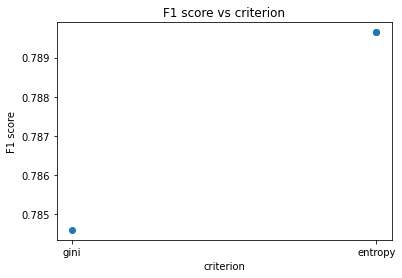

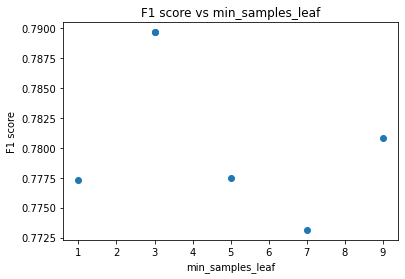

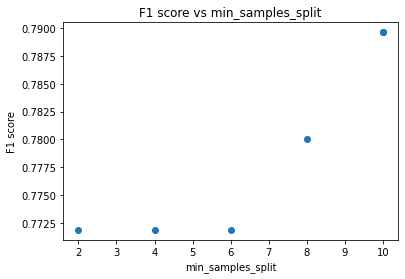

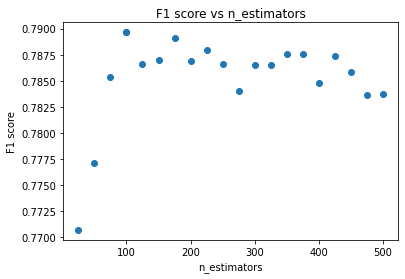

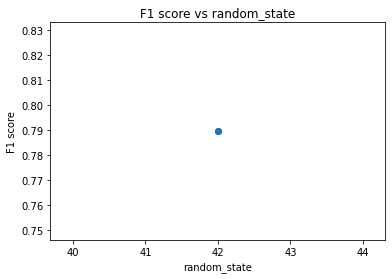

In [167]:
# plot F1 score vs parameter values for each parameter different from best params
for param in best_params:
    plt.figure()
    plt.title(f"F1 score vs {param}")
    plt.xlabel(param)
    plt.ylabel("F1 score")
    rows_to_plot = [idx for idx, row in df.iterrows() if 
        check_param_is_only_difference(param, row, best_params)]
    df_to_plot = df.iloc[rows_to_plot]
    plt.plot(df_to_plot[param], df_to_plot['f1s'], 'o')
    plt.savefig(f"{path_output_dir}/{param}_vs_f1.png")